# Session 1: Introduction to Time Series Analysis

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Define time series and understand basic notation
2. Distinguish between stationary and non-stationary processes
3. Identify and test for stationarity
4. Understand white noise and random walk processes
5. Compute and interpret autocorrelation and partial autocorrelation functions
6. Perform exploratory data analysis on financial time series

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. Time Series Basics and Notation

### 1.1 Definition

A **time series** is a sequence of observations indexed by time:

$$\{y_t\}_{t=1}^T = \{y_1, y_2, \ldots, y_T\}$$

where:
- $y_t$ is the observation at time $t$
- $T$ is the total number of observations
- $t$ can represent different time intervals (seconds, days, months, years, etc.)

### 1.2 Key Characteristics

Time series data differs from cross-sectional data in several important ways:

1. **Temporal ordering matters**: The sequence is meaningful
2. **Dependence**: Observations are typically correlated over time
3. **Trends**: Long-run movements in the data
4. **Seasonality**: Regular patterns that repeat over fixed periods
5. **Cycles**: Irregular fluctuations around the trend

### 1.3 Common Notation

- $\mu_t = E[y_t]$: Mean at time $t$
- $\sigma^2_t = Var(y_t)$: Variance at time $t$
- $\gamma_k = Cov(y_t, y_{t-k})$: Autocovariance at lag $k$
- $\rho_k = Corr(y_t, y_{t-k})$: Autocorrelation at lag $k$
- $\epsilon_t$: Error term or innovation at time $t$

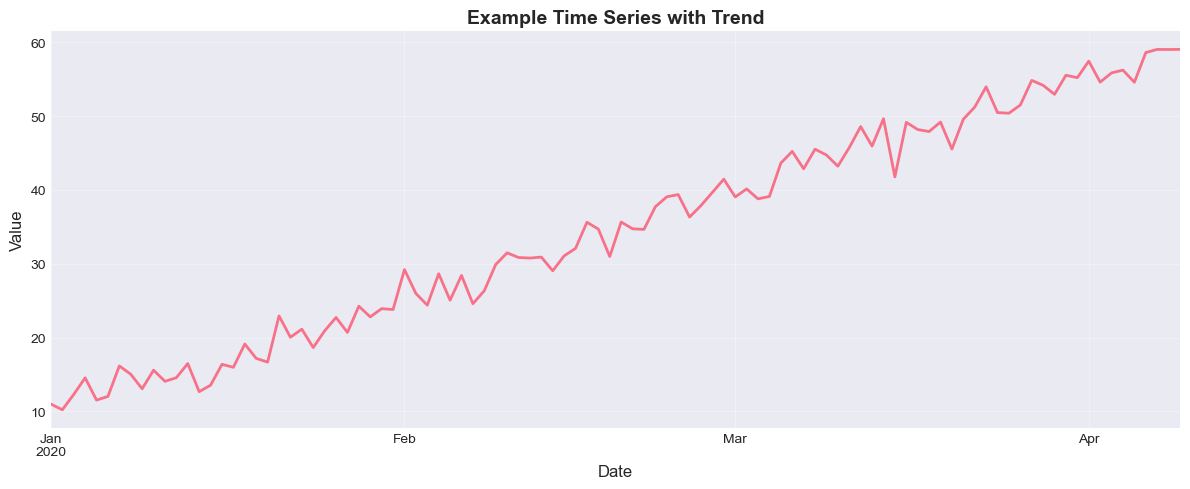

Sample size: 100
Mean: 34.54
Standard deviation: 14.70


In [4]:
# Example: Generate a simple time series
T = 100
time = np.arange(T)
y = 10 + 0.5 * time + np.random.normal(0, 2, T)

# Create a pandas Series with date index
dates = pd.date_range(start='2020-01-01', periods=T, freq='D')
ts = pd.Series(y, index=dates, name='Value')

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ts.plot(ax=ax, linewidth=2)
ax.set_title('Example Time Series with Trend', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Sample size: {len(ts)}")
print(f"Mean: {ts.mean():.2f}")
print(f"Standard deviation: {ts.std():.2f}")

## 2. Stationarity

### 2.1 Strong (Strict) Stationarity

A time series $\{y_t\}$ is **strictly stationary** if the joint distribution of $(y_{t_1}, y_{t_2}, \ldots, y_{t_k})$ is the same as that of $(y_{t_1+h}, y_{t_2+h}, \ldots, y_{t_k+h})$ for all $t_1, t_2, \ldots, t_k$ and all lags $h$.

**Implication**: The statistical properties are invariant to shifts in time.

### 2.2 Weak (Covariance) Stationarity

A time series $\{y_t\}$ is **weakly stationary** (or covariance stationary) if:

1. **Constant mean**: $E[y_t] = \mu$ for all $t$
2. **Constant variance**: $Var(y_t) = \sigma^2 < \infty$ for all $t$
3. **Autocovariance depends only on lag**: $Cov(y_t, y_{t-k}) = \gamma_k$ for all $t$ and lag $k$

### 2.3 Why Stationarity Matters

- Most time series models (ARIMA, GARCH, VAR) assume stationarity
- Non-stationary series can lead to spurious regression
- Forecasting with non-stationary data is problematic
- Many statistical properties (ergodicity, law of large numbers) require stationarity

### 2.4 Common Violations of Stationarity

1. **Trend-stationary**: $y_t = \alpha + \beta t + \epsilon_t$
2. **Difference-stationary**: $y_t = y_{t-1} + \epsilon_t$ (random walk)
3. **Structural breaks**: Parameters change at specific points in time
4. **Heteroskedasticity**: Variance changes over time

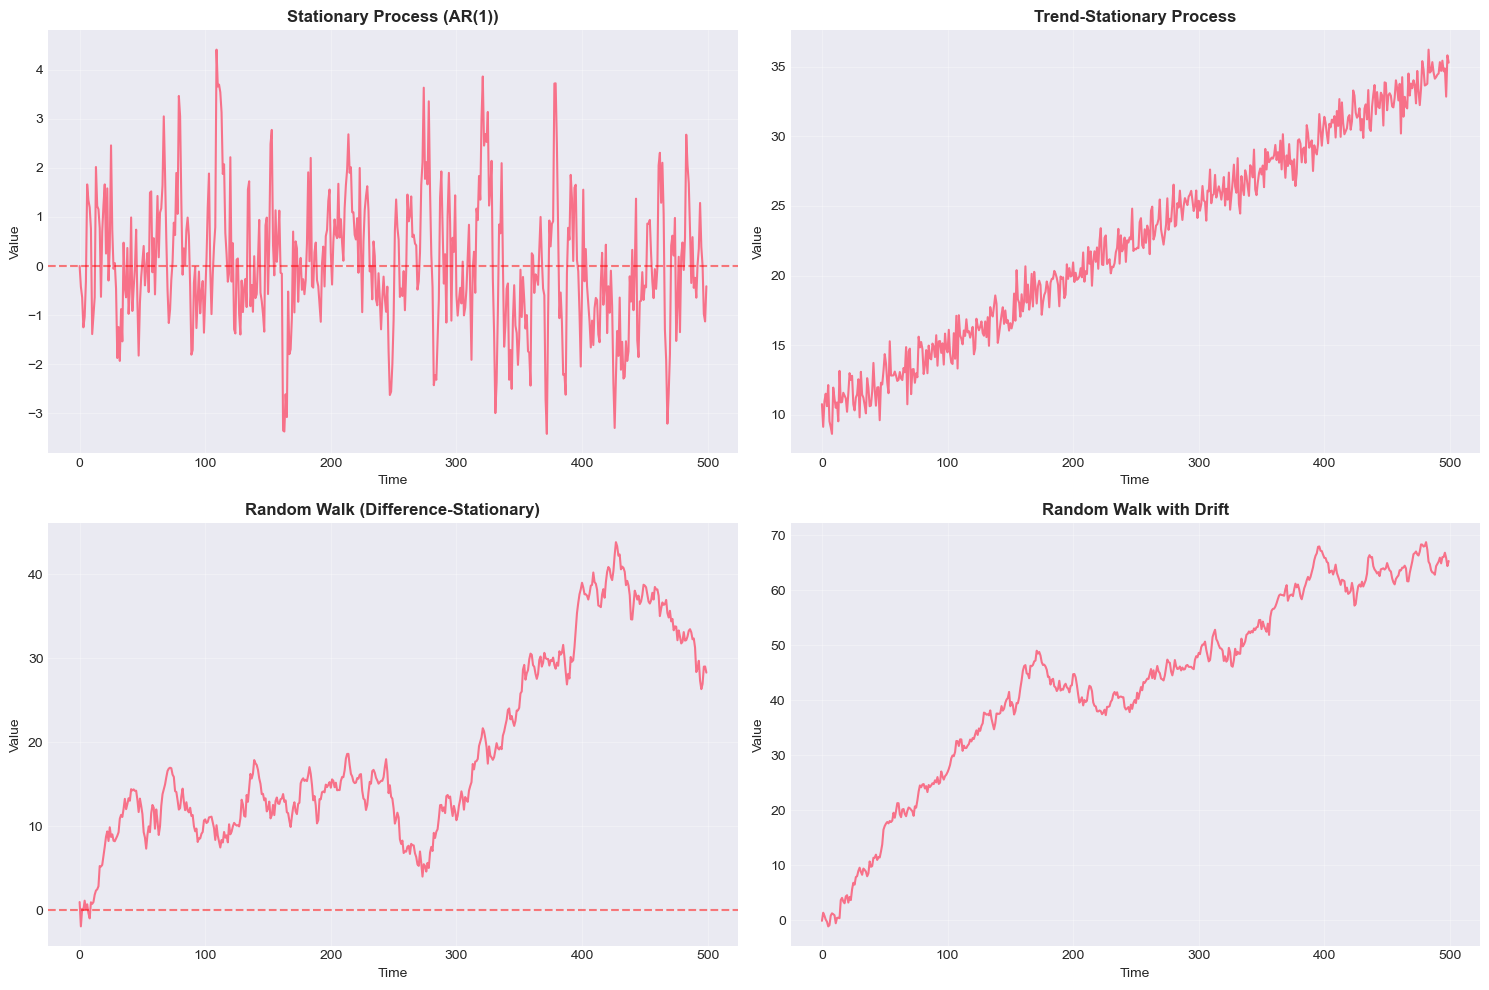

In [7]:
# Generate different types of processes
T = 500
t = np.arange(T)

# 1. Stationary process (AR(1) with |φ| < 1)
phi = 0.7
stationary = np.zeros(T)
epsilon = np.random.normal(0, 1, T)
for i in range(1, T):
    stationary[i] = phi * stationary[i-1] + epsilon[i]

# 2. Trend-stationary process
trend_stationary = 10 + 0.05 * t + np.random.normal(0, 1, T)

# 3. Difference-stationary (random walk)
random_walk = np.cumsum(np.random.normal(0, 1, T))

# 4. Random walk with drift
random_walk_drift = np.cumsum(np.random.normal(0.1, 1, T))

# Plot all processes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(stationary, linewidth=1.5)
axes[0, 0].set_title('Stationary Process (AR(1))', fontsize=12, fontweight='bold')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(trend_stationary, linewidth=1.5)
axes[0, 1].set_title('Trend-Stationary Process', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(random_walk, linewidth=1.5)
axes[1, 0].set_title('Random Walk (Difference-Stationary)', fontsize=12, fontweight='bold')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(random_walk_drift, linewidth=1.5)
axes[1, 1].set_title('Random Walk with Drift', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)

plt.tight_layout()
plt.show()

## 3. Testing for Stationarity

### 3.1 Augmented Dickey-Fuller (ADF) Test

The ADF test checks for the presence of a unit root:

$$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^p \delta_i \Delta y_{t-i} + \epsilon_t$$

**Hypotheses**:
- $H_0$: $\gamma = 0$ (unit root exists, series is non-stationary)
- $H_1$: $\gamma < 0$ (no unit root, series is stationary)

**Decision rule**: If p-value < 0.05, reject $H_0$ and conclude the series is stationary.

### 3.2 KPSS Test

The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test has opposite hypotheses:

**Hypotheses**:
- $H_0$: Series is stationary
- $H_1$: Series has a unit root

**Decision rule**: If p-value < 0.05, reject $H_0$ and conclude the series is non-stationary.

### 3.3 Combining Tests

Best practice: Use both tests for robustness

| ADF Result | KPSS Result | Conclusion |
|------------|-------------|------------|
| Stationary | Stationary  | Stationary |
| Non-stationary | Non-stationary | Non-stationary |
| Stationary | Non-stationary | Trend-stationary |
| Non-stationary | Stationary | Difference-stationary |

In [10]:
def test_stationarity(timeseries, name='Series', verbose=True):
    """
    Perform ADF and KPSS tests for stationarity.
    
    Parameters:
    -----------
    timeseries : array-like
        The time series to test
    name : str
        Name of the series for display
    verbose : bool
        Whether to print detailed results
    
    Returns:
    --------
    dict : Dictionary containing test results
    """
    
    # ADF Test
    adf_result = adfuller(timeseries, autolag='AIC')
    adf_statistic = adf_result[0]
    adf_pvalue = adf_result[1]
    adf_lags = adf_result[2]
    adf_critical_values = adf_result[4]
    
    # KPSS Test
    kpss_result = kpss(timeseries, regression='ct', nlags='auto')
    kpss_statistic = kpss_result[0]
    kpss_pvalue = kpss_result[1]
    kpss_lags = kpss_result[2]
    kpss_critical_values = kpss_result[3]
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Stationarity Tests for: {name}")
        print(f"{'='*60}")
        
        print("\n1. Augmented Dickey-Fuller Test")
        print("-" * 40)
        print(f"Test Statistic: {adf_statistic:.4f}")
        print(f"P-value: {adf_pvalue:.4f}")
        print(f"Lags used: {adf_lags}")
        print("Critical Values:")
        for key, value in adf_critical_values.items():
            print(f"  {key}: {value:.4f}")
        
        if adf_pvalue < 0.05:
            print("\n✓ ADF: Reject H0 → Series is STATIONARY (at 5% level)")
        else:
            print("\n✗ ADF: Fail to reject H0 → Series is NON-STATIONARY")
        
        print("\n2. KPSS Test")
        print("-" * 40)
        print(f"Test Statistic: {kpss_statistic:.4f}")
        print(f"P-value: {kpss_pvalue:.4f}")
        print(f"Lags used: {kpss_lags}")
        print("Critical Values:")
        for key, value in kpss_critical_values.items():
            print(f"  {key}: {value:.4f}")
        
        if kpss_pvalue < 0.05:
            print("\n✗ KPSS: Reject H0 → Series is NON-STATIONARY (at 5% level)")
        else:
            print("\n✓ KPSS: Fail to reject H0 → Series is STATIONARY")
        
        print("\n" + "="*60)
    
    return {
        'adf_statistic': adf_statistic,
        'adf_pvalue': adf_pvalue,
        'adf_is_stationary': adf_pvalue < 0.05,
        'kpss_statistic': kpss_statistic,
        'kpss_pvalue': kpss_pvalue,
        'kpss_is_stationary': kpss_pvalue >= 0.05
    }

# Test our generated series
test_stationarity(stationary, name='Stationary AR(1)')
test_stationarity(random_walk, name='Random Walk')


Stationarity Tests for: Stationary AR(1)

1. Augmented Dickey-Fuller Test
----------------------------------------
Test Statistic: -9.7416
P-value: 0.0000
Lags used: 0
Critical Values:
  1%: -3.4435
  5%: -2.8673
  10%: -2.5699

✓ ADF: Reject H0 → Series is STATIONARY (at 5% level)

2. KPSS Test
----------------------------------------
Test Statistic: 0.0571
P-value: 0.1000
Lags used: 10
Critical Values:
  10%: 0.1190
  5%: 0.1460
  2.5%: 0.1760
  1%: 0.2160

✓ KPSS: Fail to reject H0 → Series is STATIONARY


Stationarity Tests for: Random Walk

1. Augmented Dickey-Fuller Test
----------------------------------------
Test Statistic: -1.5175
P-value: 0.5248
Lags used: 0
Critical Values:
  1%: -3.4435
  5%: -2.8673
  10%: -2.5699

✗ ADF: Fail to reject H0 → Series is NON-STATIONARY

2. KPSS Test
----------------------------------------
Test Statistic: 0.5071
P-value: 0.0100
Lags used: 12
Critical Values:
  10%: 0.1190
  5%: 0.1460
  2.5%: 0.1760
  1%: 0.2160

✗ KPSS: Reject H0 → Series 

{'adf_statistic': -1.5175165267153008,
 'adf_pvalue': 0.5248290551329203,
 'adf_is_stationary': False,
 'kpss_statistic': 0.5070872812632301,
 'kpss_pvalue': 0.01,
 'kpss_is_stationary': False}

## 4. White Noise and Random Walks

### 4.1 White Noise

A **white noise** process $\{\epsilon_t\}$ satisfies:

1. $E[\epsilon_t] = 0$ for all $t$
2. $Var(\epsilon_t) = \sigma^2$ for all $t$
3. $Cov(\epsilon_t, \epsilon_s) = 0$ for all $t \neq s$

**Properties**:
- Stationary
- Unpredictable (best forecast is zero)
- Building block for more complex models

**Strong white noise** additionally assumes $\epsilon_t \sim N(0, \sigma^2)$

### 4.2 Random Walk

A **random walk** is defined as:

$$y_t = y_{t-1} + \epsilon_t$$

where $\epsilon_t$ is white noise.

**Solution**: $y_t = y_0 + \sum_{i=1}^t \epsilon_i$

**Properties**:
- Non-stationary
- $E[y_t] = y_0$ (constant)
- $Var(y_t) = t\sigma^2$ (increases with time)
- First difference is stationary: $\Delta y_t = y_t - y_{t-1} = \epsilon_t$

**Random walk with drift**:

$$y_t = \mu + y_{t-1} + \epsilon_t$$

where $\mu$ is the drift parameter.

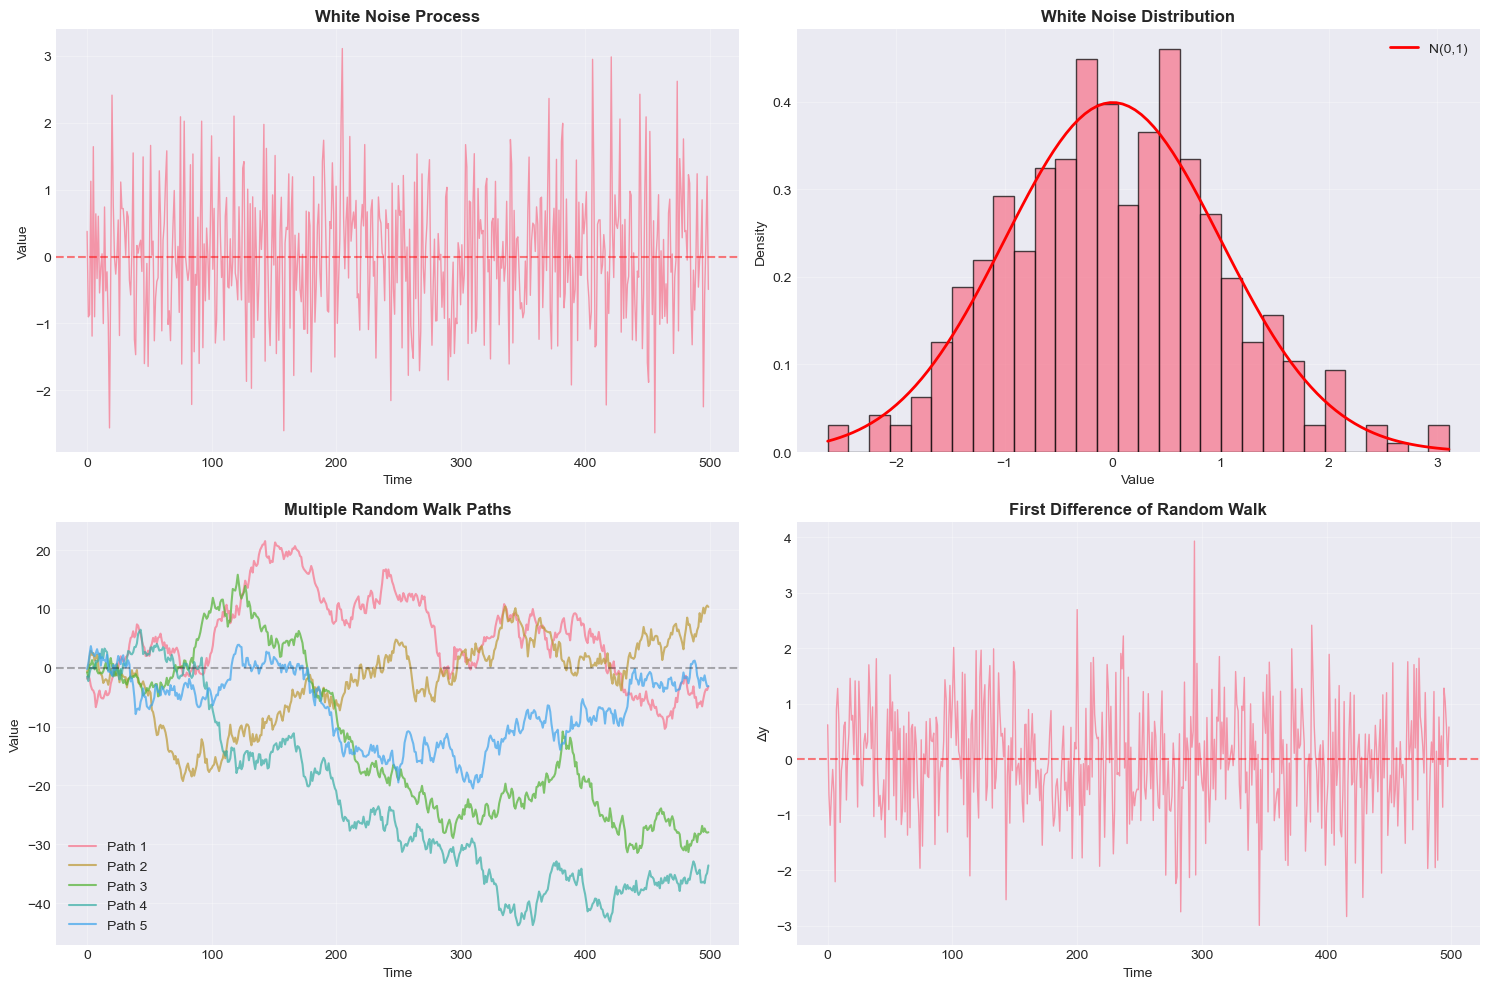


White Noise Statistics:
Mean: 0.0193 (expected: 0)
Std Dev: 0.9833 (expected: 1)
Skewness: 0.1279 (expected: 0)
Kurtosis: -0.0447 (expected: 0)

Ljung-Box Q(10): 18.7663
P-value: 0.0433
✗ Reject null: Data shows significant autocorrelation


In [12]:
# Generate and analyze white noise
T = 500
white_noise = np.random.normal(0, 1, T)

# Generate multiple random walk paths
n_paths = 5
random_walks = np.zeros((T, n_paths))
for i in range(n_paths):
    random_walks[:, i] = np.cumsum(np.random.normal(0, 1, T))

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# White noise time series
axes[0, 0].plot(white_noise, linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('White Noise Process', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# White noise histogram
axes[0, 1].hist(white_noise, bins=30, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(white_noise.min(), white_noise.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='N(0,1)')
axes[0, 1].set_title('White Noise Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Multiple random walk paths
for i in range(n_paths):
    axes[1, 0].plot(random_walks[:, i], linewidth=1.5, alpha=0.7, label=f'Path {i+1}')
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].set_title('Multiple Random Walk Paths', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Random walk first difference (should be white noise)
rw_diff = np.diff(random_walks[:, 0])
axes[1, 1].plot(rw_diff, linewidth=1, alpha=0.7)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title('First Difference of Random Walk', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Δy')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
print("\nWhite Noise Statistics:")
print(f"Mean: {white_noise.mean():.4f} (expected: 0)")
print(f"Std Dev: {white_noise.std():.4f} (expected: 1)")
print(f"Skewness: {stats.skew(white_noise):.4f} (expected: 0)")
print(f"Kurtosis: {stats.kurtosis(white_noise):.4f} (expected: 0)")

# Ljung-Box test for white noise
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(white_noise, lags=[10], return_df=True)
print(f"\nLjung-Box Q(10): {lb_result['lb_stat'].values[0]:.4f}")
print(f"P-value: {lb_result['lb_pvalue'].values[0]:.4f}")
if lb_result['lb_pvalue'].values[0] > 0.05:
    print("✓ Cannot reject null: Data consistent with white noise")
else:
    print("✗ Reject null: Data shows significant autocorrelation")

## 5. Autocorrelation and Partial Autocorrelation

### 5.1 Autocorrelation Function (ACF)

The **autocorrelation** at lag $k$ measures the correlation between $y_t$ and $y_{t-k}$:

$$\rho_k = \frac{Cov(y_t, y_{t-k})}{\sqrt{Var(y_t)Var(y_{t-k})}} = \frac{\gamma_k}{\gamma_0}$$

**Sample ACF**:

$$\hat{\rho}_k = \frac{\sum_{t=k+1}^T (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^T (y_t - \bar{y})^2}$$

**Properties**:
- $\rho_0 = 1$ (correlation with itself)
- $-1 \leq \rho_k \leq 1$
- For white noise: $\rho_k = 0$ for all $k > 0$
- Standard error (for white noise): $SE(\hat{\rho}_k) \approx 1/\sqrt{T}$

### 5.2 Partial Autocorrelation Function (PACF)

The **partial autocorrelation** at lag $k$ measures the correlation between $y_t$ and $y_{t-k}$ after removing the linear influence of $y_{t-1}, y_{t-2}, \ldots, y_{t-k+1}$.

It answers: "What is the direct correlation between $y_t$ and $y_{t-k}$?"

**Mathematical definition**: $\phi_{kk}$ is the last coefficient in:

$$y_t = \phi_{k1}y_{t-1} + \phi_{k2}y_{t-2} + \cdots + \phi_{kk}y_{t-k} + \epsilon_t$$

### 5.3 Interpreting ACF and PACF

| Process | ACF Pattern | PACF Pattern |
|---------|-------------|-------------|
| White Noise | All zero | All zero |
| AR(p) | Decays exponentially | Cuts off after lag p |
| MA(q) | Cuts off after lag q | Decays exponentially |
| ARMA(p,q) | Decays exponentially | Decays exponentially |
| Random Walk | Decays slowly | First lag ≈ 1 |

White Noise Process


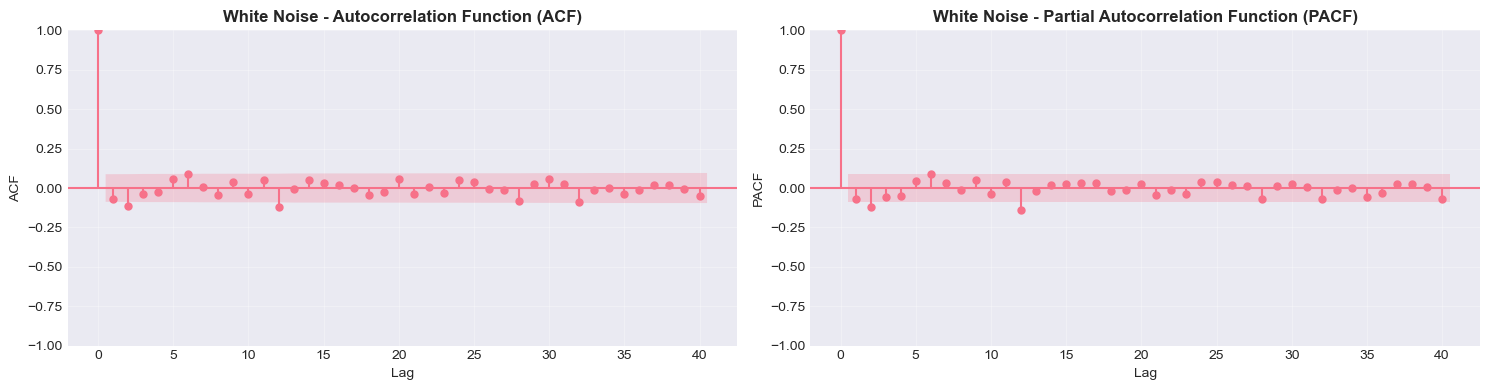


Random Walk Process


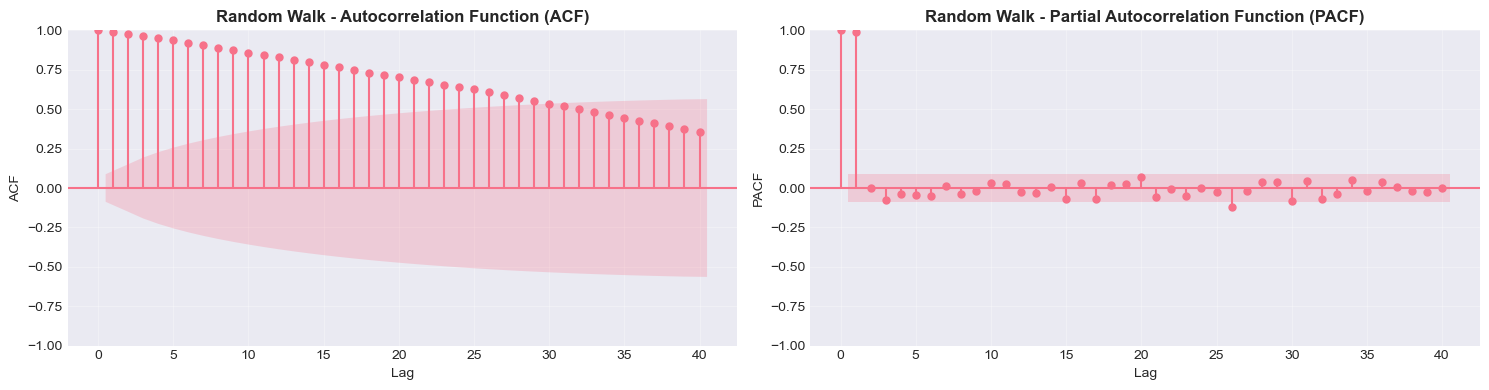


Stationary AR(1) Process


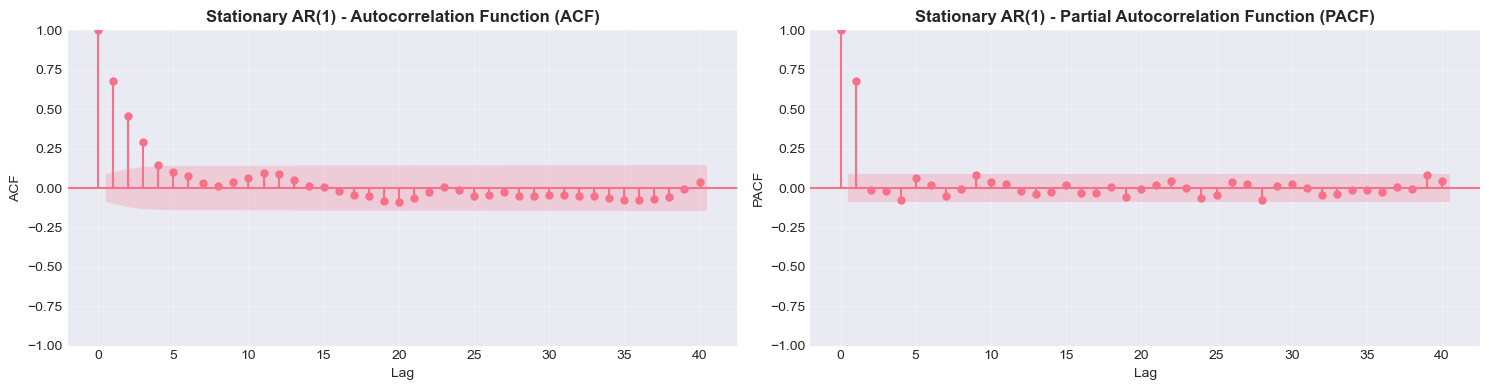

In [15]:
def plot_acf_pacf(timeseries, lags=40, title=''):
    """
    Plot ACF and PACF for a time series.
    
    Parameters:
    -----------
    timeseries : array-like
        The time series to analyze
    lags : int
        Number of lags to display
    title : str
        Title prefix for the plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot ACF
    plot_acf(timeseries, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title(f'{title} - Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Lag', fontsize=10)
    axes[0].set_ylabel('ACF', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot PACF
    plot_pacf(timeseries, lags=lags, ax=axes[1], alpha=0.05, method='ywm')
    axes[1].set_title(f'{title} - Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Lag', fontsize=10)
    axes[1].set_ylabel('PACF', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze white noise
print("White Noise Process")
plot_acf_pacf(white_noise, lags=40, title='White Noise')

# Analyze random walk
print("\nRandom Walk Process")
plot_acf_pacf(random_walks[:, 0], lags=40, title='Random Walk')

# Analyze stationary AR(1)
print("\nStationary AR(1) Process")
plot_acf_pacf(stationary, lags=40, title='Stationary AR(1)')

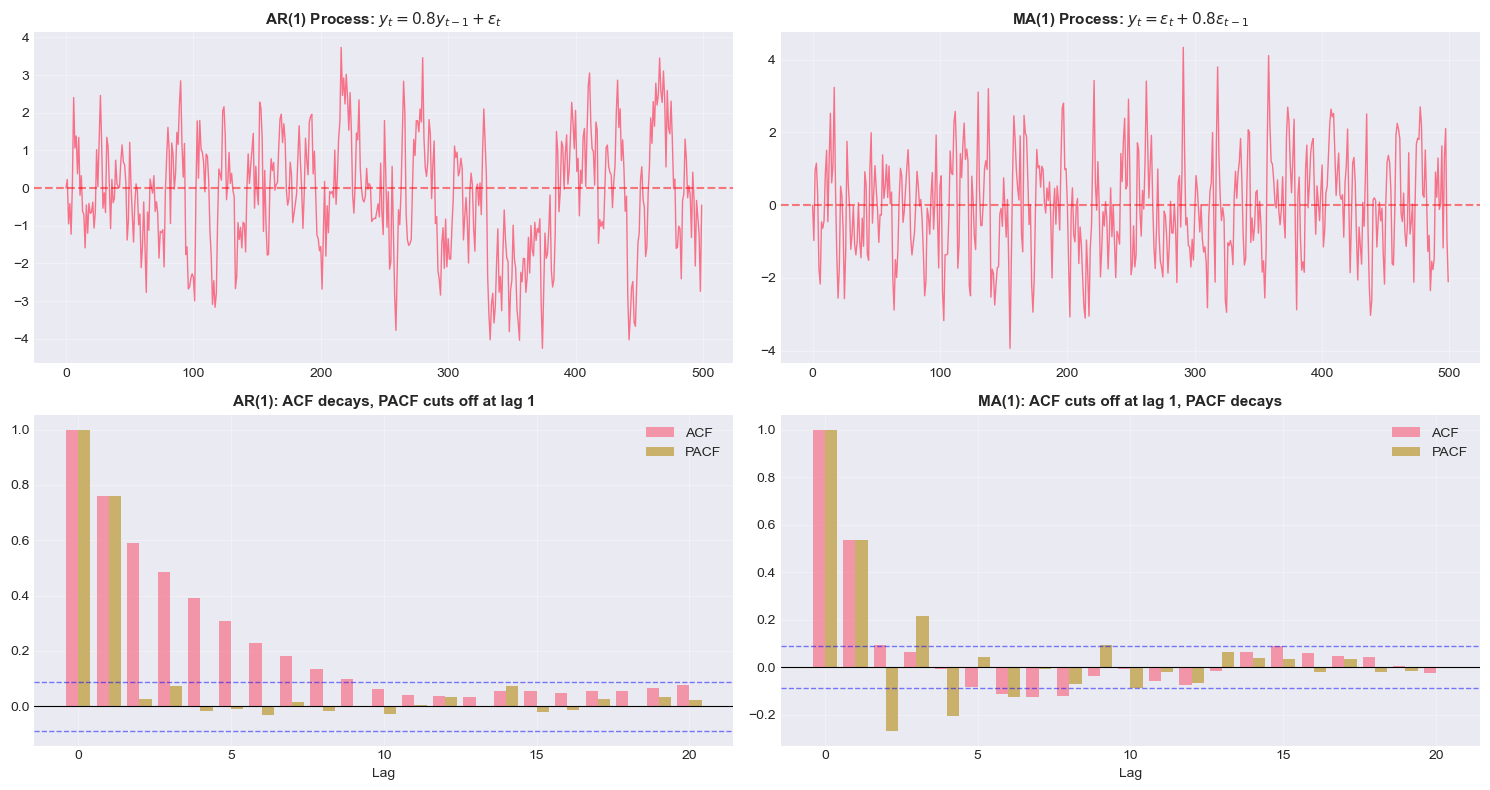


Key Observations:
• AR(1): ACF decays exponentially, PACF has significant spike only at lag 1
• MA(1): ACF has significant spike only at lag 1, PACF decays exponentially
• Blue dashed lines show 95% confidence bands (±1.96/√T)


In [19]:
# Generate and compare different processes
T = 500

# AR(1) process: y_t = 0.8*y_{t-1} + ε_t
ar1 = np.zeros(T)
eps = np.random.normal(0, 1, T)
for i in range(1, T):
    ar1[i] = 0.8 * ar1[i-1] + eps[i]

# MA(1) process: y_t = ε_t + 0.8*ε_{t-1}
ma1 = np.zeros(T)
eps = np.random.normal(0, 1, T)
for i in range(1, T):
    ma1[i] = eps[i] + 0.8 * eps[i-1]

# Plot time series
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# AR(1) time series
axes[0, 0].plot(ar1, linewidth=1)
axes[0, 0].set_title('AR(1) Process: $y_t = 0.8y_{t-1} + \epsilon_t$', fontsize=11, fontweight='bold')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)

# MA(1) time series
axes[0, 1].plot(ma1, linewidth=1)
axes[0, 1].set_title('MA(1) Process: $y_t = \epsilon_t + 0.8\epsilon_{t-1}$', fontsize=11, fontweight='bold')
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# AR(1) ACF and PACF combined
acf_ar = acf(ar1, nlags=20)
pacf_ar = pacf(ar1, nlags=20, method='ywm')
x = np.arange(len(acf_ar))
axes[1, 0].bar(x - 0.2, acf_ar, width=0.4, label='ACF', alpha=0.7)
axes[1, 0].bar(x + 0.2, pacf_ar, width=0.4, label='PACF', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linewidth=0.8)
axes[1, 0].axhline(y=1.96/np.sqrt(T), color='blue', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].axhline(y=-1.96/np.sqrt(T), color='blue', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_title('AR(1): ACF decays, PACF cuts off at lag 1', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MA(1) ACF and PACF combined
acf_ma = acf(ma1, nlags=20)
pacf_ma = pacf(ma1, nlags=20, method='ywm')
axes[1, 1].bar(x - 0.2, acf_ma, width=0.4, label='ACF', alpha=0.7)
axes[1, 1].bar(x + 0.2, pacf_ma, width=0.4, label='PACF', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linewidth=0.8)
axes[1, 1].axhline(y=1.96/np.sqrt(T), color='blue', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].axhline(y=-1.96/np.sqrt(T), color='blue', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_title('MA(1): ACF cuts off at lag 1, PACF decays', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• AR(1): ACF decays exponentially, PACF has significant spike only at lag 1")
print("• MA(1): ACF has significant spike only at lag 1, PACF decays exponentially")
print("• Blue dashed lines show 95% confidence bands (±1.96/√T)")

## 6. Practical Application: Real Financial Data

Let's apply these concepts to real financial time series data.

In [23]:
# Download financial data
print("Downloading financial data...")

# Download S&P 500 and Bitcoin data
tickers = ['^GSPC', 'BTC-USD', '^TNX']  # S&P 500, Bitcoin, 10-Year Treasury
data = yf.download(tickers, start='2020-01-01', end='2024-01-01', progress=False)

# Extract adjusted close prices
prices = data['Close']
prices.columns = ['SP500', 'BTC', 'TNX']
prices = prices.dropna()

# Calculate returns
returns = np.log(prices / prices.shift(1)).dropna() * 100  # Log returns in percentage

print(f"\nData period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Number of observations: {len(prices)}")
print(f"\nAssets: {', '.join(prices.columns)}")


Data period: 2020-01-02 to 2023-12-29
Number of observations: 1006

Assets: SP500, BTC, TNX


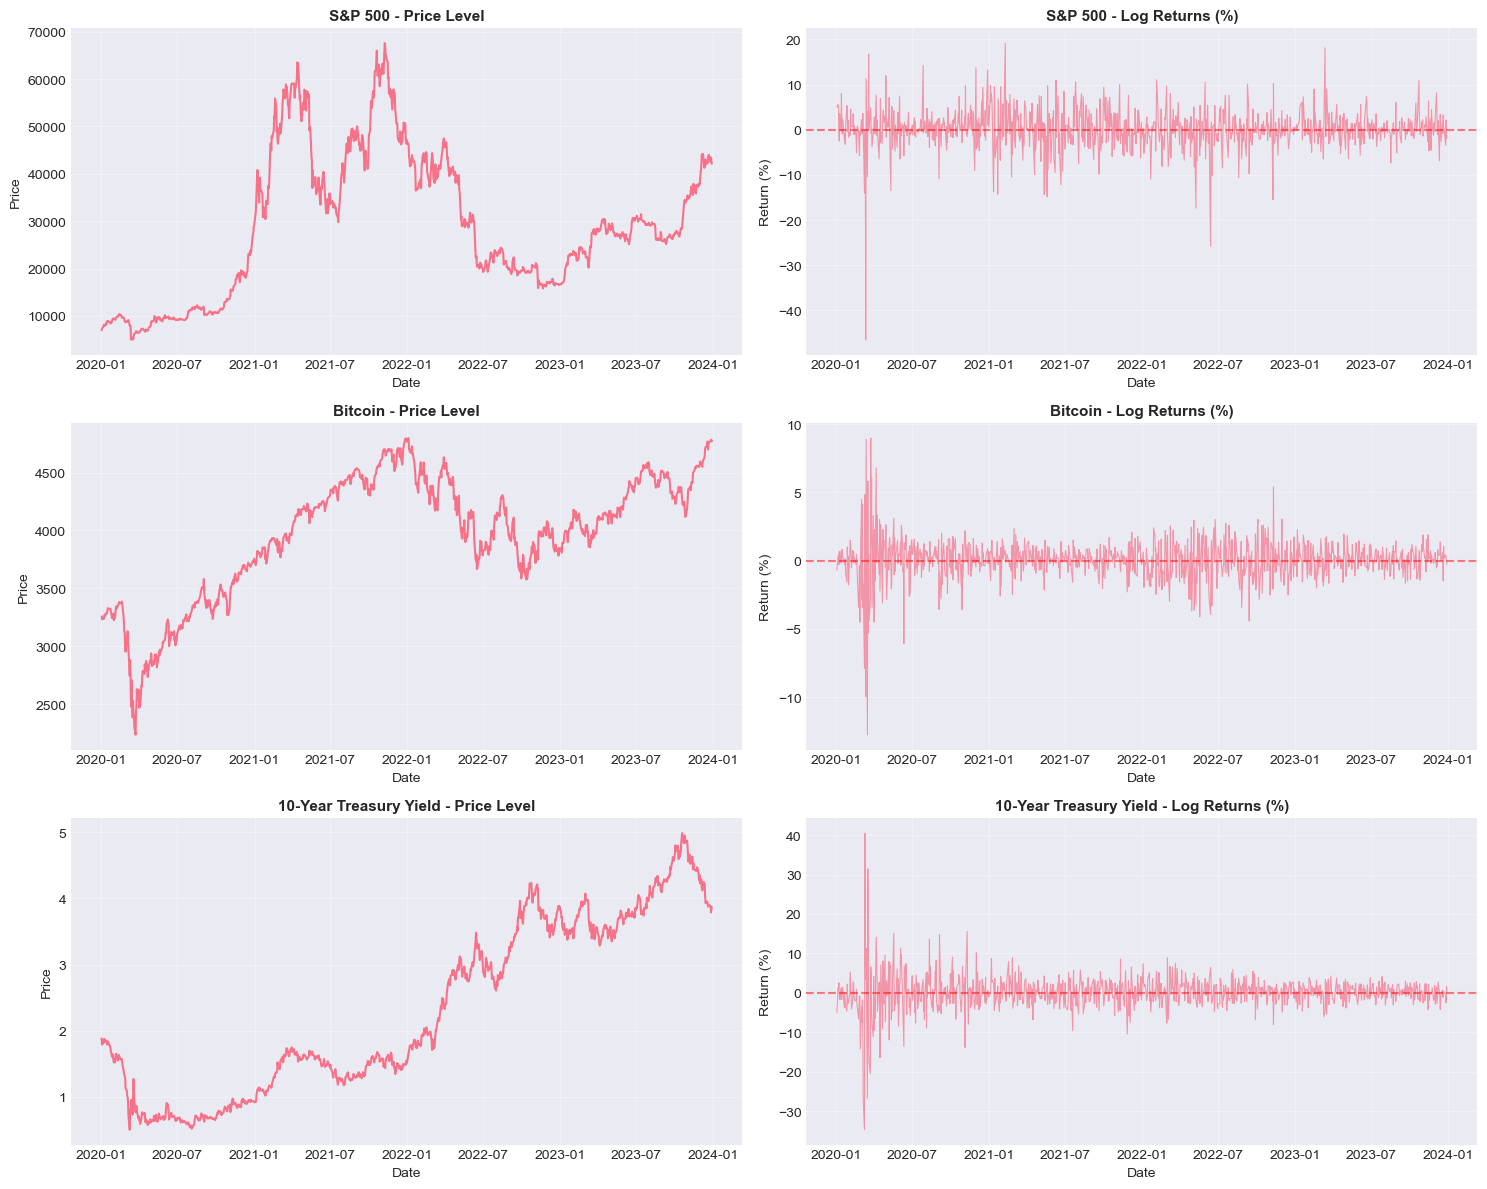

In [25]:
# Visualize price levels and returns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

assets = ['SP500', 'BTC', 'TNX']
titles = ['S&P 500', 'Bitcoin', '10-Year Treasury Yield']

for i, (asset, title) in enumerate(zip(assets, titles)):
    # Price levels
    axes[i, 0].plot(prices.index, prices[asset], linewidth=1.5)
    axes[i, 0].set_title(f'{title} - Price Level', fontsize=11, fontweight='bold')
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('Price')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Returns
    axes[i, 1].plot(returns.index, returns[asset], linewidth=0.8, alpha=0.7)
    axes[i, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[i, 1].set_title(f'{title} - Log Returns (%)', fontsize=11, fontweight='bold')
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Return (%)')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Descriptive statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)

for asset in assets:
    print(f"\n{asset}:")
    print("-" * 60)
    
    ret = returns[asset].dropna()
    
    print(f"Returns:")
    print(f"  Mean: {ret.mean():.4f}%")
    print(f"  Std Dev: {ret.std():.4f}%")
    print(f"  Min: {ret.min():.4f}%")
    print(f"  Max: {ret.max():.4f}%")
    print(f"  Skewness: {stats.skew(ret):.4f}")
    print(f"  Kurtosis: {stats.kurtosis(ret):.4f}")
    
    # Jarque-Bera test for normality
    jb_stat, jb_pval = stats.jarque_bera(ret)
    print(f"\n  Jarque-Bera test (H0: Normal distribution):")
    print(f"    Statistic: {jb_stat:.4f}")
    print(f"    P-value: {jb_pval:.6f}")
    if jb_pval < 0.05:
        print(f"    ✗ Reject normality (at 5% level)")
    else:
        print(f"    ✓ Cannot reject normality")


DESCRIPTIVE STATISTICS

SP500:
------------------------------------------------------------
Returns:
  Mean: 0.1787%
  Std Dev: 4.2935%
  Min: -46.4730%
  Max: 19.1527%
  Skewness: -1.4686
  Kurtosis: 16.5810

  Jarque-Bera test (H0: Normal distribution):
    Statistic: 11873.8520
    P-value: 0.000000
    ✗ Reject normality (at 5% level)

BTC:
------------------------------------------------------------
Returns:
  Mean: 0.0379%
  Std Dev: 1.4561%
  Min: -12.7652%
  Max: 8.9683%
  Skewness: -0.7816
  Kurtosis: 12.7312

  Jarque-Bera test (H0: Normal distribution):
    Statistic: 6889.5927
    P-value: 0.000000
    ✗ Reject normality (at 5% level)

TNX:
------------------------------------------------------------
Returns:
  Mean: 0.0716%
  Std Dev: 4.2557%
  Min: -34.7009%
  Max: 40.4797%
  Skewness: 0.2095
  Kurtosis: 20.0543

  Jarque-Bera test (H0: Normal distribution):
    Statistic: 16848.4709
    P-value: 0.000000
    ✗ Reject normality (at 5% level)


In [29]:
# Test stationarity for prices and returns
print("\n" + "="*80)
print("STATIONARITY TESTS")
print("="*80)

for asset in assets:
    print(f"\n{'='*80}")
    print(f"Asset: {asset}")
    print(f"{'='*80}")
    
    # Test price levels
    print("\n[PRICE LEVELS]")
    test_stationarity(prices[asset].dropna(), name=f'{asset} Prices', verbose=True)
    
    # Test returns
    print("\n[RETURNS]")
    test_stationarity(returns[asset].dropna(), name=f'{asset} Returns', verbose=True)


STATIONARITY TESTS

Asset: SP500

[PRICE LEVELS]

Stationarity Tests for: SP500 Prices

1. Augmented Dickey-Fuller Test
----------------------------------------
Test Statistic: -2.0154
P-value: 0.2798
Lags used: 22
Critical Values:
  1%: -3.4370
  5%: -2.8645
  10%: -2.5683

✗ ADF: Fail to reject H0 → Series is NON-STATIONARY

2. KPSS Test
----------------------------------------
Test Statistic: 0.7671
P-value: 0.0100
Lags used: 19
Critical Values:
  10%: 0.1190
  5%: 0.1460
  2.5%: 0.1760
  1%: 0.2160

✗ KPSS: Reject H0 → Series is NON-STATIONARY (at 5% level)


[RETURNS]

Stationarity Tests for: SP500 Returns

1. Augmented Dickey-Fuller Test
----------------------------------------
Test Statistic: -11.1580
P-value: 0.0000
Lags used: 6
Critical Values:
  1%: -3.4369
  5%: -2.8644
  10%: -2.5683

✓ ADF: Reject H0 → Series is STATIONARY (at 5% level)

2. KPSS Test
----------------------------------------
Test Statistic: 0.1447
P-value: 0.0524
Lags used: 6
Critical Values:
  10%: 0.1190


Autocorrelation Analysis of Returns

S&P 500


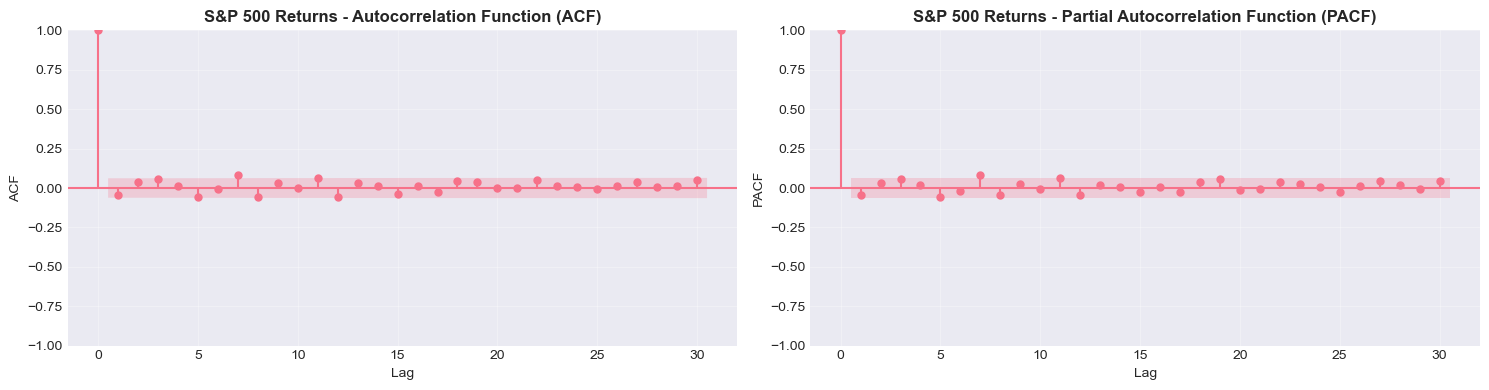


Bitcoin


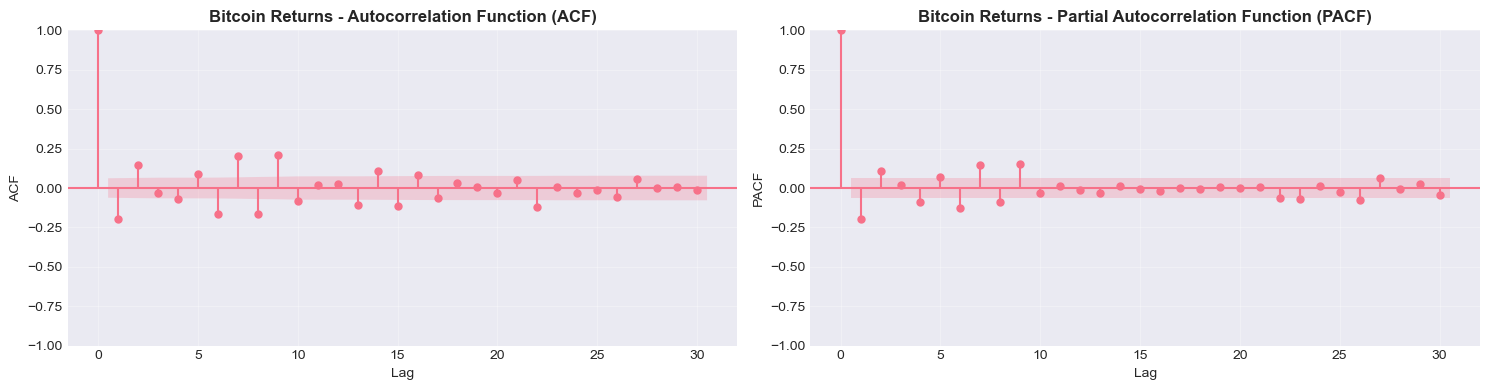


10-Year Treasury Yield


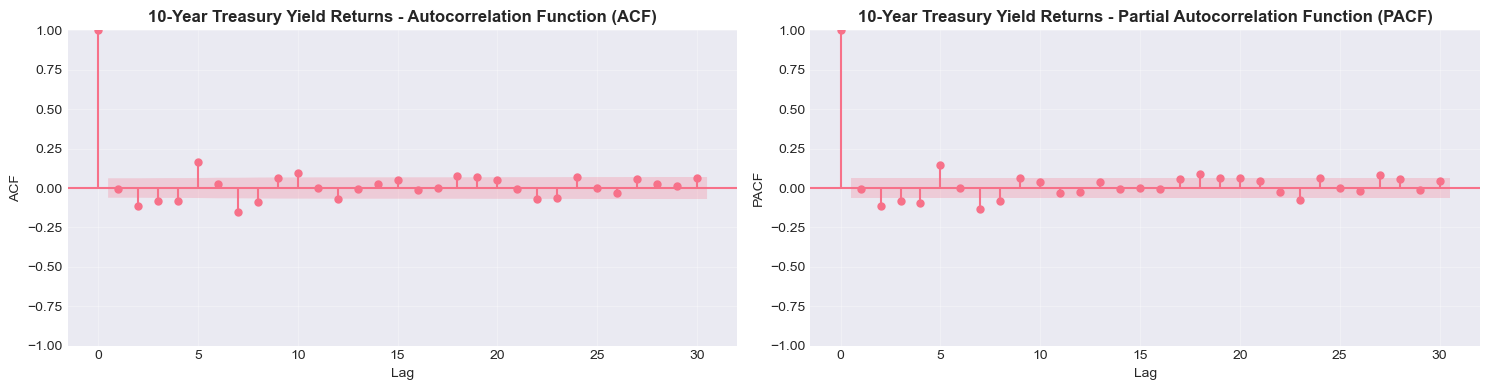

In [31]:
# ACF and PACF for returns
print("\nAutocorrelation Analysis of Returns")
print("="*80)

for asset, title in zip(assets, titles):
    print(f"\n{title}")
    plot_acf_pacf(returns[asset].dropna(), lags=30, title=f'{title} Returns')

In [33]:
# Test for autocorrelation in returns and squared returns
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box Tests for Autocorrelation")
print("="*80)

for asset, title in zip(assets, titles):
    print(f"\n{title}:")
    print("-" * 60)
    
    ret = returns[asset].dropna()
    ret_sq = ret ** 2
    
    # Test returns
    lb_ret = acorr_ljungbox(ret, lags=[10, 20], return_df=True)
    print("\nReturns:")
    print(lb_ret.to_string())
    
    # Test squared returns (proxy for volatility clustering)
    lb_sq = acorr_ljungbox(ret_sq, lags=[10, 20], return_df=True)
    print("\nSquared Returns (volatility):")
    print(lb_sq.to_string())
    
    if lb_sq['lb_pvalue'].iloc[-1] < 0.05:
        print("\n✓ Evidence of volatility clustering (GARCH effects likely)")
    else:
        print("\n✗ No strong evidence of volatility clustering")


Ljung-Box Tests for Autocorrelation

S&P 500:
------------------------------------------------------------

Returns:
      lb_stat  lb_pvalue
10  20.309707   0.026456
20  34.351273   0.023844

Squared Returns (volatility):
      lb_stat  lb_pvalue
10  21.246715   0.019437
20  22.952011   0.291157

✗ No strong evidence of volatility clustering

Bitcoin:
------------------------------------------------------------

Returns:
       lb_stat     lb_pvalue
10  223.211167  2.272727e-42
20  275.466384  8.015588e-47

Squared Returns (volatility):
        lb_stat      lb_pvalue
10  1286.284029  3.488940e-270
20  1471.811471  4.437857e-300

✓ Evidence of volatility clustering (GARCH effects likely)

10-Year Treasury Yield:
------------------------------------------------------------

Returns:
       lb_stat     lb_pvalue
10   99.660254  6.373216e-17
20  121.400995  1.568106e-16

Squared Returns (volatility):
        lb_stat      lb_pvalue
10  1173.519933  7.412772e-246
20  1222.565773  1.111894e

## 7. Key Takeaways and Summary

### Concepts Covered:

1. **Time Series Fundamentals**
   - Time series are ordered sequences where temporal dependence matters
   - Key features: trends, seasonality, cycles, and irregular components

2. **Stationarity**
   - Weak stationarity requires constant mean, variance, and autocovariance
   - Most time series models assume stationarity
   - Non-stationary series can often be made stationary through differencing or detrending

3. **Testing for Stationarity**
   - ADF test: H₀ is unit root (non-stationary)
   - KPSS test: H₀ is stationarity
   - Use both tests for robustness

4. **White Noise and Random Walks**
   - White noise is stationary and unpredictable
   - Random walks are non-stationary with variance growing over time
   - First differencing transforms random walks to white noise

5. **Autocorrelation Analysis**
   - ACF measures total correlation at each lag
   - PACF measures direct correlation after removing intermediate effects
   - ACF/PACF patterns help identify appropriate models

6. **Financial Data Characteristics**
   - Price levels are typically non-stationary
   - Returns are typically stationary but may show autocorrelation
   - Squared returns often show strong autocorrelation (volatility clustering)
   - Returns are often non-normal (fat tails, skewness)

### Next Session Preview:

In **Session 2**, we will cover:
- Classical time series decomposition
- Smoothing techniques (moving averages, exponential smoothing)
- Trend extraction methods (Hodrick-Prescott filter)
- Seasonal adjustment procedures

## 8. Exercises

### Exercise 1: Simulation Study
Generate 1000 observations from the following processes and compare their ACF/PACF:
1. AR(2): $y_t = 0.7y_{t-1} - 0.2y_{t-2} + \epsilon_t$
2. MA(2): $y_t = \epsilon_t + 0.6\epsilon_{t-1} + 0.3\epsilon_{t-2}$
3. ARMA(1,1): $y_t = 0.6y_{t-1} + \epsilon_t + 0.4\epsilon_{t-1}$

### Exercise 2: Real Data Analysis
Download data for a different asset (e.g., EUR/USD exchange rate, crude oil prices) and:
1. Test price levels and returns for stationarity
2. Examine ACF and PACF
3. Test for volatility clustering
4. Compare findings with S&P 500 results

### Exercise 3: Differencing
For a non-stationary series:
1. Apply first differencing and test for stationarity
2. If still non-stationary, apply second differencing
3. Determine the order of integration (I(0), I(1), or I(2))

### Exercise 4: Seasonal Patterns
Download monthly economic data (e.g., retail sales, unemployment rate) and:
1. Plot the series and visually identify seasonal patterns
2. Calculate ACF and look for seasonal spikes
3. Discuss implications for modeling

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

## References and Further Reading

### Textbooks:
1. Hamilton, J.D. (1994). *Time Series Analysis*. Princeton University Press.
2. Tsay, R.S. (2010). *Analysis of Financial Time Series* (3rd ed.). Wiley.
3. Brockwell, P.J., & Davis, R.A. (2016). *Introduction to Time Series and Forecasting* (3rd ed.). Springer.
4. Lütkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer.

### Papers:
1. Dickey, D.A., & Fuller, W.A. (1979). Distribution of the estimators for autoregressive time series with a unit root. *Journal of the American Statistical Association*, 74(366a), 427-431.
2. Kwiatkowski, D., Phillips, P.C., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root. *Journal of Econometrics*, 54(1-3), 159-178.

### Python Resources:
1. statsmodels documentation: https://www.statsmodels.org/
2. Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and statistical modeling with Python. *Proceedings of the 9th Python in Science Conference*.

---


**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]